# FID Calculation between two image sets

In [22]:
from pathlib import Path
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import torchvision.transforms as T
import lightning as L

from inpainting.bigtex import BigTextureDataset
from inpainting.masked_img_dataset import MaskedImageDataset
from inpainting.train import InPaintingGAN

# Settings

Customize the following paths.

In [32]:
img_dir_root = Path(r"...")
ckpt_dir_root = Path(r"...")

rocks_dir = 'rocks'
concrete_dir = 'concrete'
stripes_dir = 'stripes'
checker_dir = 'checkerboard_tiny'

save_dir_real = Path(r"...")
save_dir_fake = Path(r"...")

These will probably change each time you run this:

In [33]:
mask_size = 16
mini_path_to_ckpt = Path(r"...")
img_dir_path = img_dir_root / checker_dir
try_use_existing_real_imgs = True   # if True, does not delete and regenerate ground truth images

---

Found 1 file(s)


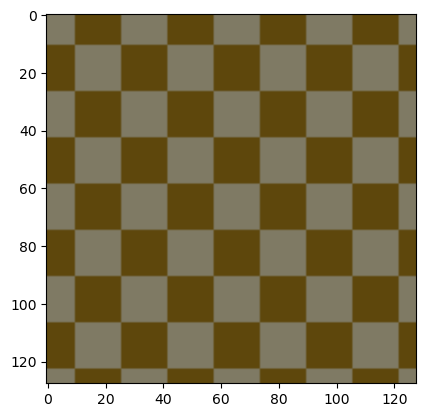

In [25]:
dataset = BigTextureDataset(img_dir_path, 128, 128, 20000)
img = dataset[0]
img = torch.permute(img, (1,2,0))
plt.imshow(img)

Clear real image directory (if required) and always clear fake image directory.

In [26]:
def clear_dir(dir_path: Path):
    files = os.listdir(str(dir_path))
    for filename in files:
        file_path = str(dir_path / filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

if not try_use_existing_real_imgs:
    clear_dir(save_dir_real)

clear_dir(save_dir_fake)

# Generate real image samples

In [27]:
if not try_use_existing_real_imgs or len(os.listdir(str(save_dir_real))) < 2048:
    for i in tqdm(range(2048)):
        img = dataset[i]
        img = torch.permute(img, (1,2,0))
        img = img.numpy()
        img = Image.fromarray(img)
        img.save(save_dir_real / f'{i}.png')
        
print('Done')

Done


# Get dataset

In [28]:
masked_dataset = MaskedImageDataset(dataset,
                                    img_size=128,
                                    mask_size=mask_size,
                                    transform=T.Compose([
                                        # T.RandomHorizontalFlip(),
                                        # T.RandomVerticalFlip(),
                                        # T.RandomRotation(45, expand=True),
                                        # T.Resize((128 * 2, 128 * 2), antialias=None),
                                        # T.CenterCrop((128,128)),
                                    ]),
                                    augs_per_example=1,
                                    use_wandering_mask=False)

# Load model and generate fake images

In [29]:
model = InPaintingGAN(masked_dataset,
                          128,
                          mask_size,
                          0.5,
                          0.99,
                          1e-4,
                          100)
model = InPaintingGAN.load_from_checkpoint(ckpt_dir_root / mini_path_to_ckpt,
                                           dataset=masked_dataset,
                                           img_size=128,
                                           mask_size=mask_size,
                                           adam_b1=0.5,
                                           adam_b2=0.99,
                                           lr=1e-4,
                                           lr_sched_step_freq=100)
model.eval()

for i in tqdm(range(2048)):
    z = model(masked_dataset[i][2].unsqueeze(0)).detach().cpu()
    z = torch.permute(z.squeeze(0), (1,2,0)).numpy()
    z = (z * 255).astype(np.uint8)
    img = Image.fromarray(z)
    img.save(save_dir_fake / f'{i}.png')

Model passed data size checks
Model passed data size checks


  0%|          | 0/2048 [00:00<?, ?it/s]

# Calculate FID

In [30]:
os.environ['save_dir_real'] = '"' + save_dir_real.as_posix() + '"'
os.environ['save_dir_fake'] = '"' + save_dir_fake.as_posix() + '"'
!python -m pytorch_fid %save_dir_real% %save_dir_fake%

FID:  319.3972903056225



100%|##########| 41/41 [00:16<00:00,  2.54it/s]

100%|##########| 41/41 [00:13<00:00,  3.14it/s]
